In [18]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [19]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [20]:
dataset_path = os.path.join('../input/anndlhw2data/Training.csv')

In [21]:
X = np.genfromtxt('../input/anndlhw2data/Training.csv',delimiter=',',skip_header=True)

In [22]:
# Pre-processing

X_max = X.max(axis=0)
X_min = X.min(axis=0)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_scaled = (X-X_min)/(X_max-X_min)

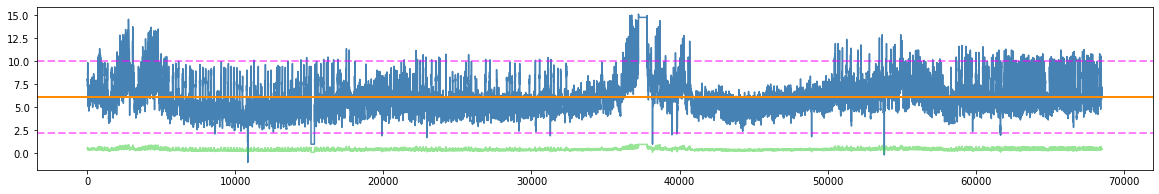

In [23]:
#for i in range(X.shape[-1]):
i=0
plt.figure(figsize=(20,3))
plt.plot(X[:,i],color='steelblue')
plt.plot(X_scaled[:,i],color='limegreen',alpha=.5)
plt.axhline(y=X_mean[i],color='darkorange',linewidth=2)
plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)
plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)

In [24]:
# generate X, y
def extract_sequences(array,sequence_length = 200,future=1,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length+future < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length:i+sequence_length+future])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [25]:
stride = 1
sequence_length = 200
future = 4
X_train, y_train = extract_sequences(X_scaled,sequence_length, future, stride)
X_train.shape,y_train.shape

((68324, 200, 7), (68324, 4, 7))

In [26]:
def build_conv(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(input_layer)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.MaxPool1D()(x)
    
    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.MaxPool1D()(x)
    
    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.MaxPool1D()(x)

    x = tfkl.Flatten()(x)
    #x = tfkl.Concatenate()([tfkl.Flatten()(x), tfkl.Flatten()(x),tfkl.Flatten()(x2)])
    x = tfkl.Dense(7*future)(x)

    
    #x2 = tfkl.LSTM(units=256)(input_layer)
    
    output_layer = tfkl.Reshape((future,7))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [27]:
input_shape = X_train.shape[1:]

model = build_conv(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 200, 16)           352       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 200, 32)           1568      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 200, 64)           6208      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 200, 128)          24704     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 200, 256)          98560     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 256)          0     

In [28]:
epochs = 100
batch_size = 256

model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

history = model.fit(
        X_train,
        y_train,
        validation_split=.1,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.7, min_lr=1e-5)
        ]
    ).history

Epoch 1/100
241/241 [==============================] - 17s 65ms/step - loss: 0.0225 - mae: 0.1062 - val_loss: 0.0106 - val_mae: 0.0763
Epoch 2/100
241/241 [==============================] - 15s 63ms/step - loss: 0.0081 - mae: 0.0656 - val_loss: 0.0062 - val_mae: 0.0567
Epoch 3/100
241/241 [==============================] - 15s 62ms/step - loss: 0.0060 - mae: 0.0561 - val_loss: 0.0054 - val_mae: 0.0526
Epoch 4/100
241/241 [==============================] - 15s 62ms/step - loss: 0.0052 - mae: 0.0519 - val_loss: 0.0048 - val_mae: 0.0494
Epoch 5/100
241/241 [==============================] - 15s 62ms/step - loss: 0.0047 - mae: 0.0493 - val_loss: 0.0043 - val_mae: 0.0468
Epoch 6/100
241/241 [==============================] - 15s 62ms/step - loss: 0.0044 - mae: 0.0475 - val_loss: 0.0049 - val_mae: 0.0520
Epoch 7/100
241/241 [==============================] - 15s 62ms/step - loss: 0.0040 - mae: 0.0456 - val_loss: 0.0041 - val_mae: 0.0469
Epoch 8/100
241/241 [==============================] - 

In [29]:
future_window = 864

In [34]:
def autoregression_pred_multiout(model,window,future,future_window):
    last_window = X_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape
    pred = np.array([])
    X_temp = last_window
    for t in range(0,future_window,future):
        pred_temp = model.predict(X_temp)
        #pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,future:,:],pred_temp), axis=1)

    pred_scaled = pred[0]*(X_max-X_min)+X_min
    return pred_scaled

In [35]:
pred = autoregression_pred_multiout(model,sequence_length,future,future_window)

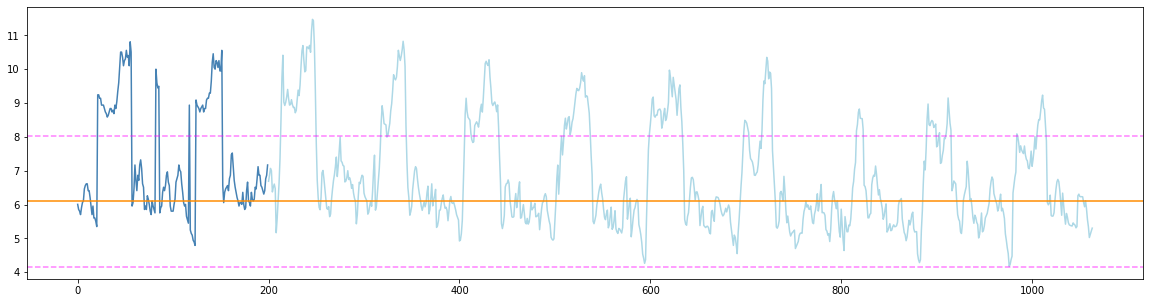

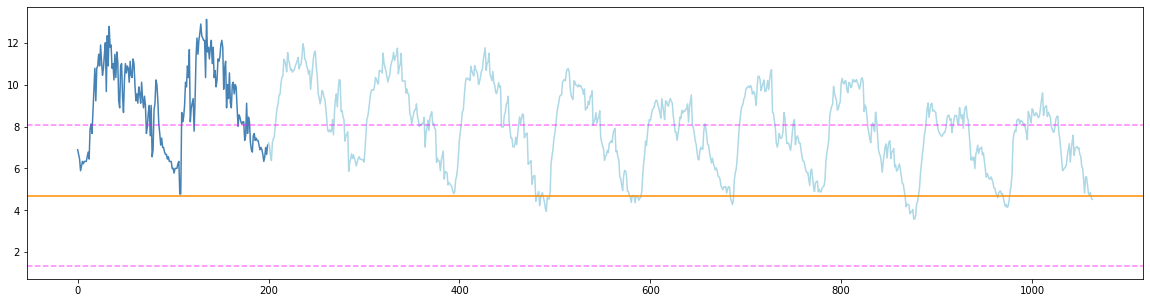

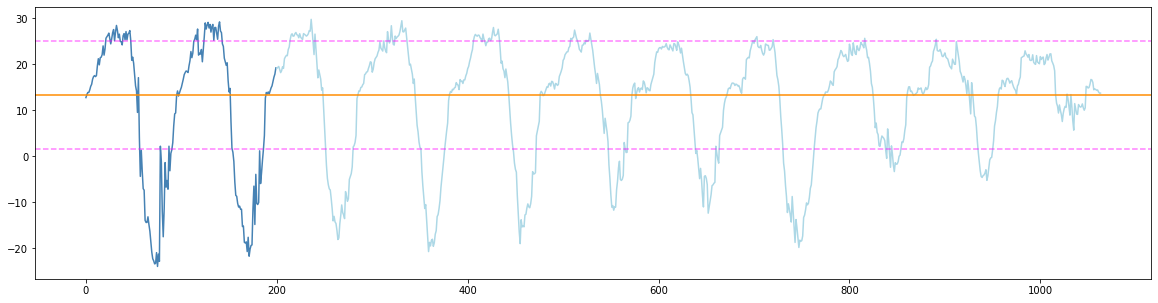

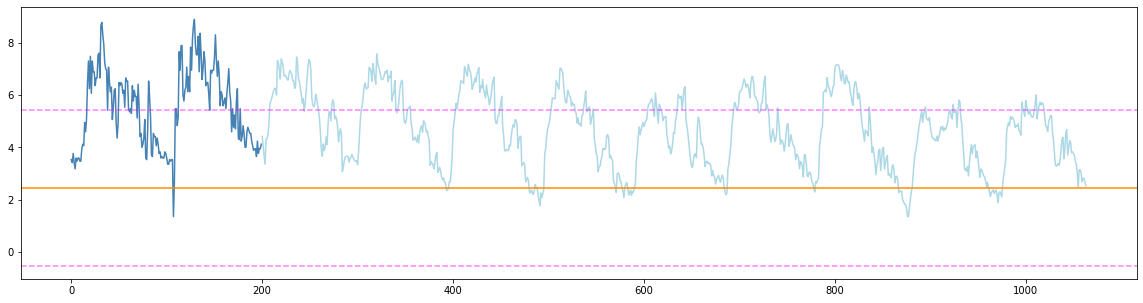

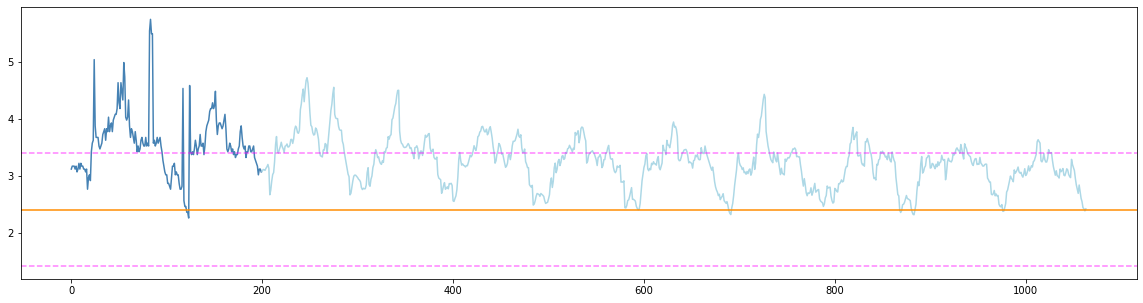

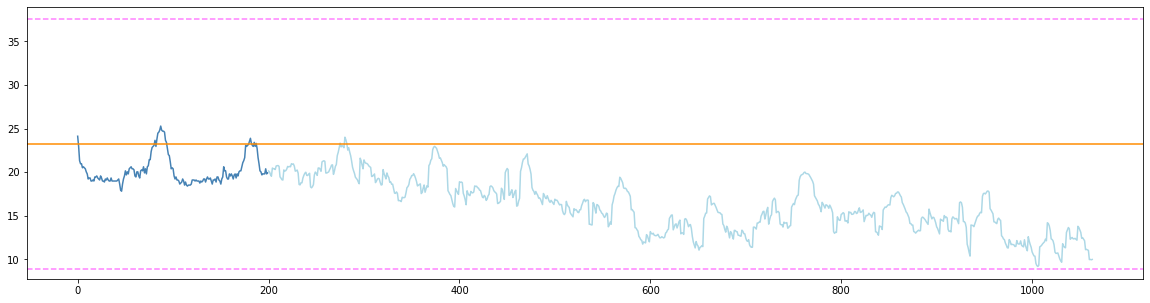

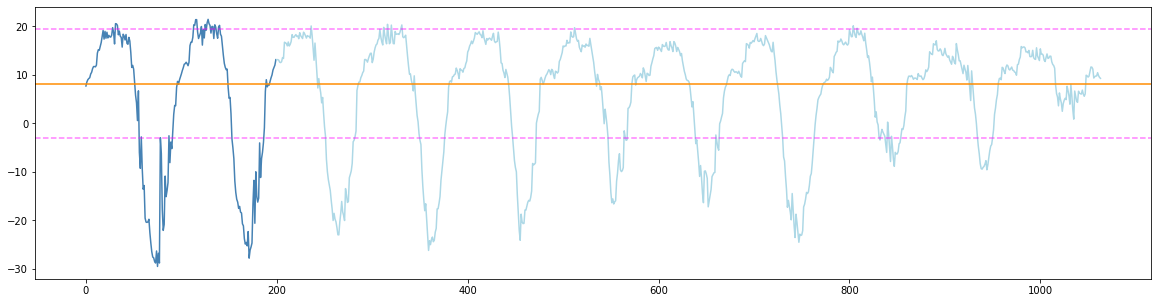

In [37]:
window = sequence_length
for i in range(pred.shape[-1]):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),X[-window:,i],color='steelblue')
    plt.plot(range(window,window+future_window),pred[:,i],color='lightblue')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)

In [ ]:
#for i in range(pred_scaled.shape[-1]):
#    plt.figure(figsize=(20,5))
#    plt.plot(range(window),train_scaled[-window:,i])
#    plt.plot(range(window,window+future_window),val_scaled[:future_window,i])
#    plt.plot(range(window,window+future_window),pred[0,:,i])


In [ ]:
best_epoch = np.argmin(history['val_loss'])
fig_size = (15,5)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# SCORE 4.0981531143, same with no state and no layer norm

In [38]:
model.save('model')
#model = tfk.models.load_model('model')
!zip -r model.zip model

2022-01-18 21:02:31.538372: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 74%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: model/keras_metadata.pb (deflated 95%)
